# Reducing JIT Compilation time

## The Problem

One characteristic of `jax.jit` is that it asks to XLA to compile every operation it traces. This can lead to very long compilation times when working with large quantum circuits.

If the circuit has a repeating structure, as is common in e.g. parameterized quantum circuits, we can simply ask JAX to compile a single repetition of the circuit and reuse it multiple times.

`qujax` makes this easy through a convenience function called `repeat_circuit`. This notebook illustrates how to use this function and shows what happens when we do not.

## Imports

In [1]:
from typing import List, Tuple
import time

import jax
from jax.random import PRNGKey

import qujax
from qujax import print_circuit, repeat_circuit, all_zeros_statetensor

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Circuit definition

In [2]:
def circuit(
    n_qubits: int, depth: int
) -> Tuple[List[str], List[List[int]], List[List[int]], int]:
    gates: List[str] = []
    qubit_inds: List[List[int]] = []
    param_inds: List[List[int]] = []

    parameter_index = 0

    for _ in range(depth):
        # Rx layer
        for i in range(n_qubits):
            gates.append("Rx")
            qubit_inds.append([i])
            param_inds.append([parameter_index])
            parameter_index += 1

        # Rz layer
        for i in range(0, n_qubits):
            gates.append("Rz")
            qubit_inds.append([i])
            param_inds.append([parameter_index])
            parameter_index += 1

        # CRz layer
        for i in range(n_qubits - 1):
            gates.append("CRz")
            qubit_inds.append([i, i + 1])
            param_inds.append([parameter_index])
            parameter_index += 1

    return gates, qubit_inds, param_inds, parameter_index

Print one repetition of the circuit to visually check for correctness

In [3]:
gates, qubit_inds, param_inds, nr_of_parameters = circuit(4, 1)

In [4]:
print_circuit(gates, qubit_inds, param_inds);

q0: ---Rx[0]---Rz[4]-----◯-------------------
                         |                   
q1: ---Rx[1]---Rz[5]---CRz[8]----◯-----------
                                 |           
q2: ---Rx[2]---Rz[6]-----------CRz[9]----◯---
                                         |   
q3: ---Rx[3]---Rz[7]------------------CRz[10]


## Compute compilation times

In [5]:
n_qubits = 12
circuit_depths = list(range(4, 25, 4))
rng_seed = 0

**Using** the `repeat_circuit` function

In [6]:
optimised_times_list = []
rng_key = PRNGKey(rng_seed)

for d in circuit_depths:
    # qujax specification of circuit
    gates, qubit_inds, param_inds, nr_of_parameters = circuit(n_qubits, 1)

    # Get function that returns one application of the circuit
    params_to_statetensor = qujax.get_params_to_statetensor_func(
        gates, qubit_inds, param_inds
    )

    rng_key, parameters_rng = jax.random.split(rng_key)

    random_angles = jax.random.uniform(parameters_rng, (d * nr_of_parameters,))

    # Allow for an arbitrary number of circuit repetitions while avoiding compilation overhead
    repeated_circuit = jax.jit(repeat_circuit(params_to_statetensor, nr_of_parameters))

    initial_state = all_zeros_statetensor(n_qubits)

    start = time.time()
    repeated_circuit.lower(random_angles, initial_state).compile()
    elapsed = time.time() - start

    optimised_times_list.append(elapsed)

**Not using** the `repeat_circuit` function

In [7]:
unoptimised_times_list = []
rng_key = PRNGKey(rng_seed)

for d in circuit_depths:
    # qujax specification of circuit
    gates, qubit_inds, param_inds, nr_of_parameters = circuit(n_qubits, d)

    params_to_statetensor = jax.jit(
        qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)
    )

    rng_key, parameters_rng = jax.random.split(rng_key)

    random_angles = jax.random.uniform(parameters_rng, (d * nr_of_parameters,))

    start = time.time()
    params_to_statetensor.lower(random_angles).compile()
    elapsed = time.time() - start

    unoptimised_times_list.append(elapsed)

# Plot results

In [8]:
import matplotlib.pyplot as plt

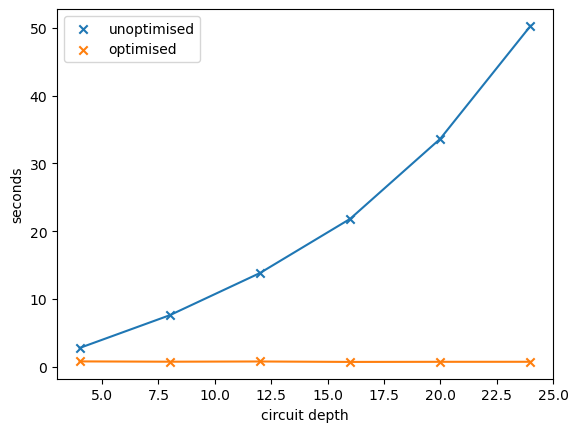

In [10]:
plt.plot(circuit_depths, unoptimised_times_list)
plt.scatter(circuit_depths, unoptimised_times_list, marker="x", label="unoptimised")
plt.plot(circuit_depths, optimised_times_list)
plt.scatter(circuit_depths, optimised_times_list, marker="x", label="optimised")
plt.xlabel("circuit depth")
plt.ylabel(r"seconds")
plt.legend();

Awesome!